# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [120]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [322]:
 # define your regions here
presel = {
    
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )", 
#             "lep_fj_dr": "( ( lep_fj_dr<0.8) )",   
            
            ### signal region
#             "LepIsolation": " ( (lep_pt<55) & (lep_isolation<0.15) ) | (lep_pt>=55)",
#             "LepMisolation": " ( (lep_pt>=55) & (lep_misolation<0.2) ) | (lep_pt<55)",
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#             "lep_fj_dr": "( ( lep_fj_dr<0.8) )",               
            ### signal region
#             "LepIsolation": " ( (lep_pt<120) & (lep_isolation<0.15) ) | (lep_pt>=120)",
        },
}

samples_dir = {
    "2016":    "../eos/postprocessOct13_hidNeurons_2016",
    "2016APV": "../eos/postprocessOct13_hidNeurons_2016APV",    
    "2017":    "../eos/postprocessOct9_hidNeurons_2017",
    "2018":    "../eos/postprocessOct5_hidNeurons_2018",
}

In [7]:
from make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2017", "2018"]

events_dict = {}
events_dict["signal_region"] = {}
events_dict["qcd_region"] = {}
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict["signal_region"] = {**events_dict["signal_region"], **out}
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="qcd_region")
    events_dict["qcd_region"] = {**events_dict["qcd_region"], **out}

INFO:root:Finding DYJetsToLL_M-50_HT-600to800 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 165029 events
INFO:root:Will fill the DYJets dataframe with the remaining 165029 events
INFO:root:tot event weight 3057.8149388615484 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3841 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3841 events
INFO:root:tot event weight 6124.89967450774 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 129307 events
INFO:root:Will fill the DYJets dataframe with the remaining 129307 events
INFO:root:tot event weight 1192.4418136251331 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil s

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 27132 events
INFO:root:Will fill the SingleTop dataframe with the remaining 27132 events
INFO:root:tot event weight 90.69283597942014 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017D
INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 20199 events
INFO:root:Will fill the DYJets dataframe with the remaining 20199 events
INFO:root:tot event weight 3209.123960653712 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 893 events
INFO:root:Will fill the QCD dataframe with the remaining 893 events
INFO:root:tot event weight 0.6085285580482859 

INFO:root:Finding SingleMuon_Run2017E

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 137982 events
INFO:root:Will fill the Data dataframe with the remaining 137982 events
INFO:root:tot event weight 137982.0 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2507 events
INFO:root:Will fill the QCD dataframe with the remaining 2507 events
INFO:root:tot event weight 140.87281175011913 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 275 events
INFO:root:Will fill the WZQQ dataframe with the remaining 275 events
INFO:root:tot event weight 646.0768030041115 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Appl

INFO:root:tot event weight 19.091754732214866 

INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 11290 events
INFO:root:Will fill the SingleTop dataframe with the remaining 11290 events
INFO:root:tot event weight 2624.153750420281 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3 events
INFO:root:Will fill the WZQQ dataframe with the remaining 3 events
INFO:root:tot event weight 12.66880964237167 

INFO:root:Finding SingleElectron_Run2017E samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2017E
INFO:root:Finding SingleElectron_Run2017B samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2017B
INFO:root:Finding DYJetsToLL_M-50_HT-800to1200 samp

INFO:root:tot event weight 11571.118016544318 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1106 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1106 events
INFO:root:tot event weight 112.70734185535028 

INFO:root:Finding DYJetsToLL_M-50_HT-1200to2500 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 111156 events
INFO:root:Will fill the DYJets dataframe with the remaining 111156 events
INFO:root:tot event weight 293.52562678831174 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 997 events
INFO:root:Will fill the WZQQ dataframe with the remaining 997 events
INFO:root:tot event weight 131.84437394603194 

INFO:root:Finding QCD_Pt_1

INFO:root:Applying lep_fj_dr selection on 89396 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 89396 events
INFO:root:tot event weight 4942.339336658926 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 402714 events
INFO:root:Will fill the TTbar dataframe with the remaining 402714 events
INFO:root:tot event weight 39455.67199146389 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 609481 events
INFO:root:Will fill the DYJets dataframe with the remaining 609481 events
INFO:root:tot event weight 4153.83161094316 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 22150 events
IN

INFO:root:Will fill the TTbar dataframe with the remaining 312785 events
INFO:root:tot event weight 9618.911203798045 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 595 events
INFO:root:Will fill the QCD dataframe with the remaining 595 events
INFO:root:tot event weight 0.042066141982240075 

INFO:root:Finding DYJetsToLL_Pt-650ToInf samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 108098 events
INFO:root:Will fill the DYJets dataframe with the remaining 108098 events
INFO:root:tot event weight 92.83467235478943 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 414 events
INFO:root:Will fill the WZQQ dataframe with the remaining 414 events
INFO:root:tot ev

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1604 events
INFO:root:Will fill the QCD dataframe with the remaining 1604 events
INFO:root:tot event weight 3.8706650954782984 

INFO:root:Finding DYJetsToLL_M-50_HT-200to400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6653 events
INFO:root:Will fill the DYJets dataframe with the remaining 6653 events
INFO:root:tot event weight 11277.578054198115 

INFO:root:Finding DYJetsToLL_Pt-100To250 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 216186 events
INFO:root:Will fill the DYJets dataframe with the remaining 216186 events
INFO:root:tot event weight 10457.939081891218 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under

INFO:root:Applying lep_fj_dr selection on 8 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8 events
INFO:root:tot event weight 14.271903926482299 

INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 461539 events
INFO:root:Will fill the Data dataframe with the remaining 461539 events
INFO:root:tot event weight 461539.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3353 events
INFO:root:Will fill the SingleTop dataframe with the remaining 3353 events
INFO:root:tot event weight 10.795219135426986 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 202157 events
INFO:root:Will fill the Data dataframe with the remaining 202157 events
INFO:root:tot event weight 202157.0 

INFO:root:Findi

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6155 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6155 events
INFO:root:tot event weight 7.880818881206833 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1397 events
INFO:root:Will fill the ttH dataframe with the remaining 1397 events
INFO:root:tot event weight 4.821959373615649 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 21802 events
INFO:root:Will fill the WZQQ dataframe with the remaining 21802 events
INFO:root:tot event weight 1683.1205790120757 

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2017F
INFO:root:Finding QCD_Pt_800to1000 s

INFO:root:Applying lep_fj_dr selection on 35486 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 35486 events
INFO:root:tot event weight 19690.326851379636 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4758 events
INFO:root:Will fill the SingleTop dataframe with the remaining 4758 events
INFO:root:tot event weight 1021.5104960261068 

INFO:root:Finding SingleElectron_Run2016H samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 86174 events
INFO:root:Will fill the Data dataframe with the remaining 86174 events
INFO:root:tot event weight 86174.0 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 5530 events
INFO:root:Will fill the ggF dataframe with the remaining 553

INFO:root:tot event weight 331.9735622076878 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4745 events
INFO:root:Will fill the QCD dataframe with the remaining 4745 events
INFO:root:tot event weight 9729.561682766527 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1129 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1129 events
INFO:root:tot event weight 113.14766546183901 

INFO:root:Finding DYJetsToLL_M-50_HT-1200to2500 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 86180 events
INFO:root:Will fill the DYJets dataframe with the remaining 86180 events
INFO:root:tot event weight 192.2200094688584 

INFO:root:Finding ZJetsToQQ_HT-600to8

INFO:root:Applying lep_fj_dr selection on 6121 events
INFO:root:Will fill the VH dataframe with the remaining 6121 events
INFO:root:tot event weight 3.5852746632601695 

INFO:root:Finding DYJetsToLL_M-50_HT-70to100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1 events
INFO:root:Will fill the DYJets dataframe with the remaining 1 events
INFO:root:tot event weight 9.803557085253058 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 92490 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 92490 events
INFO:root:tot event weight 4965.602872075632 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 87877 events
INFO:root:Will fill the TT

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 224 events
INFO:root:Will fill the WZQQ dataframe with the remaining 224 events
INFO:root:tot event weight 78.46443907215826 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 180 events
INFO:root:Will fill the Diboson dataframe with the remaining 180 events
INFO:root:tot event weight 29.223011376303468 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4781 events
INFO:root:Will fill the TTbar dataframe with the remaining 4781 events
INFO:root:tot event weight 204.7505414683313 

INFO:root:Finding GluGluZH_HToWW_ZTo2L_M-125 samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4889 events
INF

INFO:root:Applying lep_fj_dr selection on 45010 events
INFO:root:Will fill the DYJets dataframe with the remaining 45010 events
INFO:root:tot event weight 788.6362761047385 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1032 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1032 events
INFO:root:tot event weight 1747.8948892264252 

INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2016H
INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2016F
INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 100903 events
INFO:root:Will fill the DYJets dataframe with the remaining

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2370 events
INFO:root:Will fill the DYJets dataframe with the remaining 2370 events
INFO:root:tot event weight 89.46599919061246 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 981 events
INFO:root:Will fill the QCD dataframe with the remaining 981 events
INFO:root:tot event weight 0.27455738032758564 

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3005 events
INFO:root:Will fill the Diboson dataframe with the remaining 3005 events
INFO:root:tot event weight 239.44280865050385 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 14003 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 14003 events
INFO:root:tot event weight 7214.2481495514385 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 5336 events
INFO:root:Will fill the QCD dataframe with the remaining 5336 events
INFO:root:tot event weight 923.3403361949406 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 7240 events
INFO:root:Will fill the VH dataframe with the remaining 7240 events
INFO:root:tot event weight 3.7929612044730523 

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1264 events
INFO:root:Will

INFO:root:tot event weight 191.66254906421563 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 21 events
INFO:root:Will fill the WZQQ dataframe with the remaining 21 events
INFO:root:tot event weight 74.33720969600223 

INFO:root:Finding QCD_Pt_120to170 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 401 events
INFO:root:Will fill the QCD dataframe with the remaining 401 events
INFO:root:tot event weight 105602.18910754289 

INFO:root:Finding DYJetsToLL_M-50_HT-800to1200 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 152 events
INFO:root:Will fill the DYJets dataframe with the remaining 152 events
INFO:root:tot event weight 25.780845087439463 

INFO:root:Finding QCD_Pt_3200toInf samples and

INFO:root:tot event weight 579.607064600656 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 8013 events
INFO:root:Will fill the WZQQ dataframe with the remaining 8013 events
INFO:root:tot event weight 1440.477995278205 

INFO:root:Finding DYJetsToLL_M-50_HT-100to200 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 14 events
INFO:root:Will fill the DYJets dataframe with the remaining 14 events
INFO:root:tot event weight 19.522161039584013 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4032 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4032 events
INFO:root:tot event weight 3.3915745471391836 

INFO:root:Finding ttHToNonb

INFO:root:Will fill the WJetsLNu dataframe with the remaining 77435 events
INFO:root:tot event weight 1087.6926178924978 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 40308 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 40308 events
INFO:root:tot event weight 20983.82143392765 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4144 events
INFO:root:Will fill the SingleTop dataframe with the remaining 4144 events
INFO:root:tot event weight 1074.5663791753607 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6336 events
INFO:root:Will fill the ggF dataframe with the re

INFO:root:tot event weight 19.96626451393177 

INFO:root:Finding SingleElectron_Run2016D_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 42553 events
INFO:root:Will fill the Data dataframe with the remaining 42553 events
INFO:root:tot event weight 42553.0 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 6524 events
INFO:root:Will fill the QCD dataframe with the remaining 6524 events
INFO:root:tot event weight 341.71796411530676 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4348 events
INFO:root:Will fill the QCD dataframe with the remaining 4348 events
INFO:root:tot event weight 10229.92883598261 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using alrea

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 24752 events
INFO:root:Will fill the DYJets dataframe with the remaining 24752 events
INFO:root:tot event weight 101.5519149578942 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 657 events
INFO:root:Will fill the VBF dataframe with the remaining 657 events
INFO:root:tot event weight 27.66867605276004 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 5281 events
INFO:root:Will fill the VH dataframe with the remaining 5281 events
INFO:root:tot event weight 3.925818045851607 

INFO:root:Finding DYJetsToLL_M-50_HT-70to100 samples and should combine them

INFO:root:Applying lep_fj_dr selection on 35656 events
INFO:root:Will fill the Data dataframe with the remaining 35656 events
INFO:root:tot event weight 35656.0 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 16469 events
INFO:root:Will fill the SingleTop dataframe with the remaining 16469 events
INFO:root:tot event weight 553.1999260880441 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 215039 events
INFO:root:Will fill the TTbar dataframe with the remaining 215039 events
INFO:root:tot event weight 7836.2369425501365 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 269 events
INFO:root:Will fill the QC

INFO:root:Applying lep_fj_dr selection on 115 events
INFO:root:Will fill the WZQQ dataframe with the remaining 115 events
INFO:root:tot event weight 99.45824221304892 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 46495 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 46495 events
INFO:root:tot event weight 23310.24265820247 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2867 events
INFO:root:Will fill the QCD dataframe with the remaining 2867 events
INFO:root:tot event weight 606.8049915076375 

INFO:root:Finding SingleMuon_Run2016C_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 21675 events
INFO:root:Will fill the Data dataframe with the remaining 21675 events
INFO:root:

INFO:root:Will fill the SingleTop dataframe with the remaining 2554 events
INFO:root:tot event weight 671.5237600811527 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 12 events
INFO:root:Will fill the WZQQ dataframe with the remaining 12 events
INFO:root:tot event weight 36.43888356264937 

INFO:root:Finding DYJetsToLL_M-50_HT-800to1200 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 58520 events
INFO:root:Will fill the DYJets dataframe with the remaining 58520 events
INFO:root:tot event weight 490.07424409392115 

INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 223 events
INFO:root:Will fill the QCD dataframe with the remaining 223 events
INFO:root:tot e

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 580 events
INFO:root:Will fill the WZQQ dataframe with the remaining 580 events
INFO:root:tot event weight 56.89770410427741 

INFO:root:Finding SingleMuon_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2016B_ver2_HIPM
INFO:root:Finding SingleMuon_Run2016E_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2016E_HIPM
INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 602 events
INFO:root:Will fill the QCD dataframe with the remaining 602 events
INFO:root:tot event weight 51488.82849841761 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 26333 events
INFO:

INFO:root:tot event weight 3409.257219365967 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3941 events
INFO:root:Will fill the DYJets dataframe with the remaining 3941 events
INFO:root:tot event weight 13.038906166486194 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 9805 events
INFO:root:Will fill the SingleTop dataframe with the remaining 9805 events
INFO:root:tot event weight 300.20572843588064 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1961 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1961 events
INFO:root:tot event weight 16.23542886142

INFO:root:Will fill the Diboson dataframe with the remaining 97 events
INFO:root:tot event weight 16.476298690436156 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 69282 events
INFO:root:Will fill the TTbar dataframe with the remaining 69282 events
INFO:root:tot event weight 3701.534969951679 

INFO:root:Finding GluGluZH_HToWW_ZTo2L_M-125 samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 384 events
INFO:root:Will fill the Diboson dataframe with the remaining 384 events
INFO:root:tot event weight 0.003046310118564076 

INFO:root:Finding DYJetsToLL_M-50_HT-2500toInf samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 24 events
INFO:root:Will fill the DYJets dataframe with the remaining 24 events
INFO:

INFO:root:Applying lep_fj_dr selection on 696 events
INFO:root:Will fill the DYJets dataframe with the remaining 696 events
INFO:root:tot event weight 174.0726694615808 

INFO:root:Finding DYJetsToLL_Pt-100To250 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 4932 events
INFO:root:Will fill the DYJets dataframe with the remaining 4932 events
INFO:root:tot event weight 100.81061292304304 

INFO:root:Finding DYJetsToLL_M-50_HT-600to800 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 20890 events
INFO:root:Will fill the DYJets dataframe with the remaining 20890 events
INFO:root:tot event weight 4105.954541984247 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2873 events
INFO:root:Will

INFO:root:Will fill the DYJets dataframe with the remaining 17482 events
INFO:root:tot event weight 3993.301913370198 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 845 events
INFO:root:Will fill the QCD dataframe with the remaining 845 events
INFO:root:tot event weight 0.792805277581828 

INFO:root:Finding SingleMuon_Run2018A samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018A
INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 3708 events
INFO:root:Will fill the Diboson dataframe with the remaining 3708 events
INFO:root:tot event weight 1046.48297707746 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:

INFO:root:Will fill the QCD dataframe with the remaining 2194 events
INFO:root:tot event weight 169.44936924344427 

INFO:root:Finding EGamma_Run2018B samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 69674 events
INFO:root:Will fill the Data dataframe with the remaining 69674 events
INFO:root:tot event weight 69674.0 

INFO:root:Finding SingleMuon_Run2018C samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018C
INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 253 events
INFO:root:Will fill the WZQQ dataframe with the remaining 253 events
INFO:root:tot event weight 757.9058079858174 

INFO:root:Finding SingleMuon_Run2018D samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018D
INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under W

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 13021 events
INFO:root:Will fill the SingleTop dataframe with the remaining 13021 events
INFO:root:tot event weight 3218.802094196274 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding DYJetsToLL_M-50_HT-800to1200 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 123439 events
INFO:root:Will fill the DYJets dataframe with the remaining 123439 events
INFO:root:tot event weight 1421.9481039441298 

INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 29 events
INFO:root:W

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 216126 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 216126 events
INFO:root:tot event weight 26839.196695986695 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 491 events
INFO:root:Will fill the WZQQ dataframe with the remaining 491 events
INFO:root:tot event weight 184.33997978533074 

INFO:root:Finding DYJetsToLL_M-50_HT-100to200 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2824 events
INFO:root:Will fill the DYJets dataframe with the remaining 2824 events
INFO:root:tot event weight 1959.6775901930503 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applyin

INFO:root:Applying lep_fj_dr selection on 535775 events
INFO:root:Will fill the DYJets dataframe with the remaining 535775 events
INFO:root:tot event weight 5582.769242856433 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 26174 events
INFO:root:Will fill the SingleTop dataframe with the remaining 26174 events
INFO:root:tot event weight 812.3119233253092 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 127 events
INFO:root:Will fill the SingleTop dataframe with the remaining 127 events
INFO:root:tot event weight 1.0357274863495263 

INFO:root:Finding DYJetsToLL_M-50_HT-400to600 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr sele

INFO:root:Applying lep_fj_dr selection on 12696 events
INFO:root:Will fill the Diboson dataframe with the remaining 12696 events
INFO:root:tot event weight 0.17265822278956328 

INFO:root:Finding DYJetsToLL_M-50_HT-2500toInf samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 36554 events
INFO:root:Will fill the DYJets dataframe with the remaining 36554 events
INFO:root:tot event weight 9.527570075882057 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 2311 events
INFO:root:Will fill the QCD dataframe with the remaining 2311 events
INFO:root:tot event weight 51.84495114914267 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 1813 events
INFO:root:Will fill the QCD da

INFO:root:No parquet file for SingleMuon_Run2018B
INFO:root:Finding DYJetsToLL_M-50_HT-600to800 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 715 events
INFO:root:Will fill the DYJets dataframe with the remaining 715 events
INFO:root:tot event weight 150.42788366430537 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 101 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 101 events
INFO:root:tot event weight 220.84266291467492 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 416 events
INFO:root:Will fill the DYJets dataframe with the remaining 416 events
INFO:root:tot event weight 5.761001294756529 

INFO:root:Finding VBF

INFO:root:tot event weight 581724.0 

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 465 events
INFO:root:Will fill the Diboson dataframe with the remaining 465 events
INFO:root:tot event weight 131.3304359765511 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 10346 events
INFO:root:Will fill the SingleTop dataframe with the remaining 10346 events
INFO:root:tot event weight 364.9498653059014 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 30935 events
INFO:root:Will fill the TTbar dataframe with the remaining 30935 events
INFO:root:tot event weight 1371.588018082607 

INFO:root:Finding QCD_Pt_2400to3200 samples an

INFO:root:tot event weight 4913.098272979174 

INFO:root:Finding SingleMuon_Run2018D samples and should combine them under Data
INFO:root:Applying lep_fj_dr selection on 1093263 events
INFO:root:Will fill the Data dataframe with the remaining 1093263 events
INFO:root:tot event weight 1093263.0 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 7185 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 7185 events
INFO:root:tot event weight 3910.9961490836276 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 17153 events
INFO:root:Will fill the QCD dataframe with the remaining 17153 events
INFO:root:tot event weight 40247.71305593133 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Usi

In [7]:
events_dict.keys()

dict_keys(['signal_region'])

In [8]:
events_dict["signal_region"].keys()

dict_keys(['2017', '2016', '2016APV', '2018'])

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

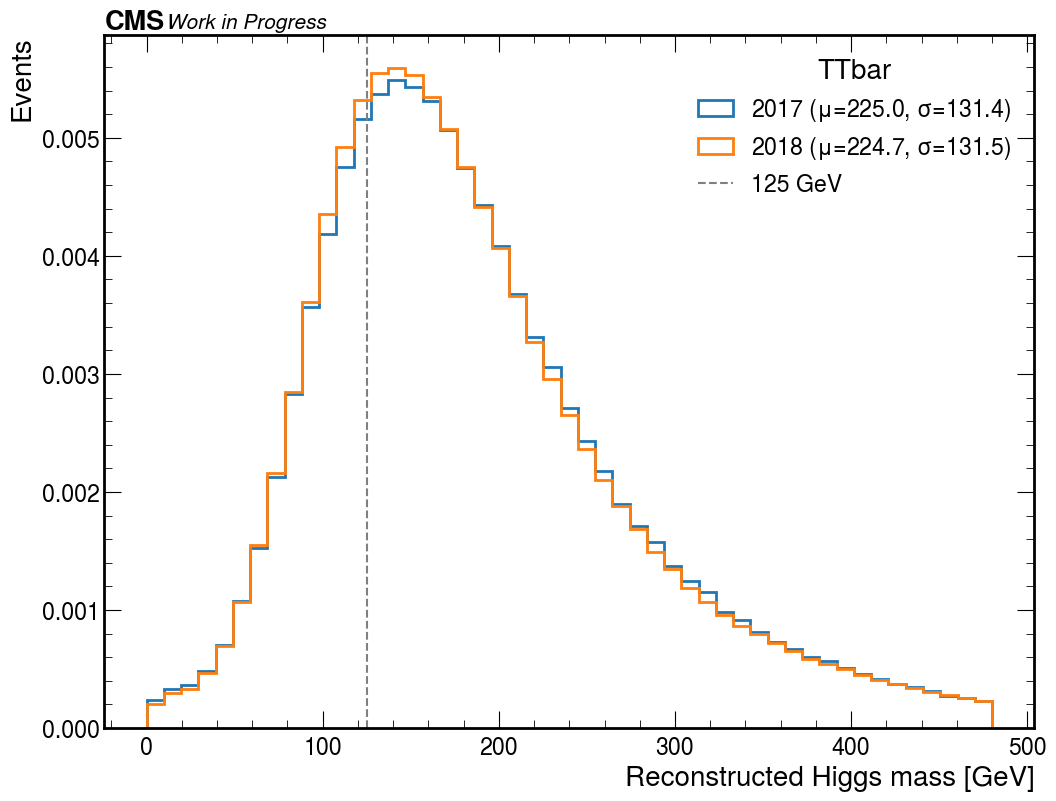

In [187]:
plt.rcParams.update({"font.size": 20})

bins = 50

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "TTbar"
channels = ["ele", "mu"]
region = "signal_region"

fig, ax = plt.subplots(figsize=(12, 9))

for year in ["2017", "2018"]:
        
    df1 = events_dict[region][year]["mu"][sample]    
    df2 = events_dict[region][year]["ele"][sample]

    df = pd.concat([df1, df2])
    
    x = df["rec_higgs_m"]
    w = df["event_weight"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=w,
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{year} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

# hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")        

In [11]:
# tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8]
# tagger_cuts = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
# tagger_cuts = np.linspace(0.7, 0.97, 28)

# tagger_cuts = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]
# tagger_cuts = [0.90, 0.925, 0.95, 0.975, 0.99]

tagger_cuts = np.linspace(0.9, 0.99, 19)
# tagger_cuts = np.linspace(0.9, 0.99, 19*2-1)
# tagger_cuts = np.linspace(0.2, 0.97, 30)
# tagger_cuts = np.linspace(0.1, 0.85, 25)

# wp = 0.85
mass_window = [50, 200]

years = ["2017", "2018", "2016", "2016APV"]
channels = ["ele", "mu"]

s_over_b = {}

for tagger in [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_HPO",

    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:

        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict["signal_region"][year][ch]:
                    df = events_dict["signal_region"][year][ch][sample]

                    # add tagger cut
                    df = df[df[tagger]>tagger_cut]
                    # add mass window
                    df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                    # remove high weight events
                    df = df[df["event_weight"]<145]

                    # add inverted tagger cut
#                     df = df[df[tagger]<wp]

                    ##############################    
                    if "WJets" in sample:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.9
tagger cut 0.905
tagger cut 0.91
tagger cut 0.915
tagger cut 0.92
tagger cut 0.925
tagger cut 0.93
tagger cut 0.935
tagger cut 0.9400000000000001
tagger cut 0.9450000000000001
tagger cut 0.95
tagger cut 0.955
tagger cut 0.96
tagger cut 0.965
tagger cut 0.97
tagger cut 0.975
tagger cut 0.98
tagger cut 0.985
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned_v2_nor2
tagger cut 0.9
tagger cut 0.905
tagger cut 0.91
tagger cut 0.915
tagger cut 0.92
tagger cut 0.925
tagger cut 0.93
tagger cut 0.935
tagger cut 0.9400000000000001
tagger cut 0.9450000000000001
tagger cut 0.95
tagger cut 0.955
tagger cut 0.96
tagger cut 0.965
tagger cut 0.97
tagger cut 0.975
tagger cut 0.98
tagger cut 0.985
tagger cut 0.99


In [19]:
# tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8]
# tagger_cuts = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


# tagger_cuts = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]
# tagger_cuts = [0.90, 0.925, 0.95, 0.975, 0.99]

# tagger_cuts = np.linspace(0.9, 0.99, 19)
tagger_cuts = np.linspace(0.7, 0.97, 28)
# tagger_cuts = np.linspace(0.1, 0.85, 25)

wp = 0.97
mass_window = [80, 160]

years = ["2017", "2018", "2016", "2016APV"]

channels = ["ele", "mu"]

s_over_b = {}

for tagger in [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_HPO",

    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:

        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict["signal_region"][year][ch]:
                    if sample=="Data":
                        continue
                        
                    df = events_dict["signal_region"][year][ch][sample]

                    # add tagger cut
                    df = df[df[tagger]>tagger_cut]
                    # add mass window
                    df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                    # remove high weight events
                    df = df[df["event_weight"]<145]

                    # add inverted tagger cut
                    df = df[df[tagger]<wp]

                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.7
tagger cut 0.71
tagger cut 0.72
tagger cut 0.73
tagger cut 0.74
tagger cut 0.75
tagger cut 0.76
tagger cut 0.77
tagger cut 0.7799999999999999
tagger cut 0.7899999999999999
tagger cut 0.7999999999999999
tagger cut 0.8099999999999999
tagger cut 0.82
tagger cut 0.83
tagger cut 0.84
tagger cut 0.85
tagger cut 0.86
tagger cut 0.87
tagger cut 0.8799999999999999
tagger cut 0.8899999999999999
tagger cut 0.8999999999999999
tagger cut 0.9099999999999999
tagger cut 0.9199999999999999
tagger cut 0.9299999999999999
tagger cut 0.94
tagger cut 0.95
tagger cut 0.96
tagger cut 0.97


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_73990/3119391320.py:67: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b[tagger].append(s/math.sqrt(b))


TAGGER: fj_ParT_score_finetuned_v2_nor2
tagger cut 0.7
tagger cut 0.71
tagger cut 0.72
tagger cut 0.73
tagger cut 0.74
tagger cut 0.75
tagger cut 0.76
tagger cut 0.77
tagger cut 0.7799999999999999
tagger cut 0.7899999999999999
tagger cut 0.7999999999999999
tagger cut 0.8099999999999999
tagger cut 0.82
tagger cut 0.83
tagger cut 0.84
tagger cut 0.85
tagger cut 0.86
tagger cut 0.87
tagger cut 0.8799999999999999
tagger cut 0.8899999999999999
tagger cut 0.8999999999999999
tagger cut 0.9099999999999999
tagger cut 0.9199999999999999
tagger cut 0.9299999999999999
tagger cut 0.94
tagger cut 0.95
tagger cut 0.96
tagger cut 0.97


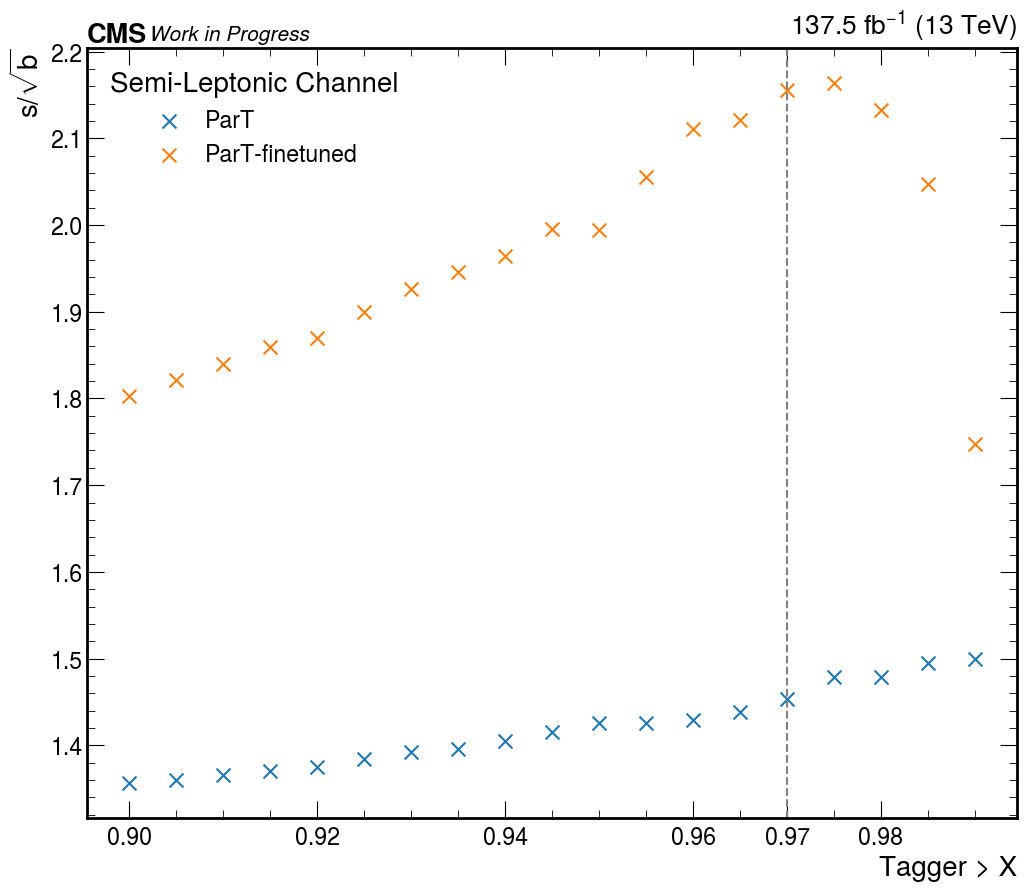

In [18]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",
    f"fj_ParT_score_finetuned_v2_nor2",
]:
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.97, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"$s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])


lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/soverb_high_signal_region.pdf")

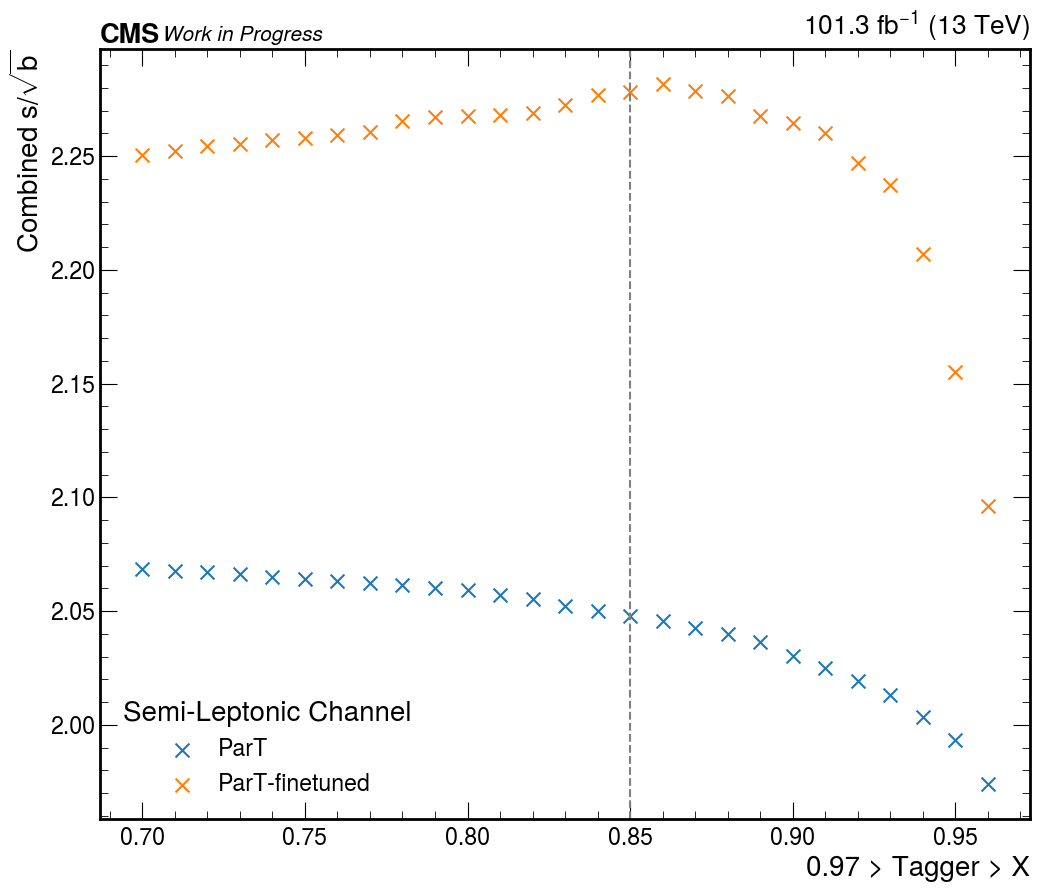

In [20]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))
years = ["2018", "2017"]


soverb_high = 1.95

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",
    f"fj_ParT_score_finetuned_v2_nor2",
]:
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.85, color="grey", linestyle="--")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"Combined $s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_medium_signal_region.pdf")

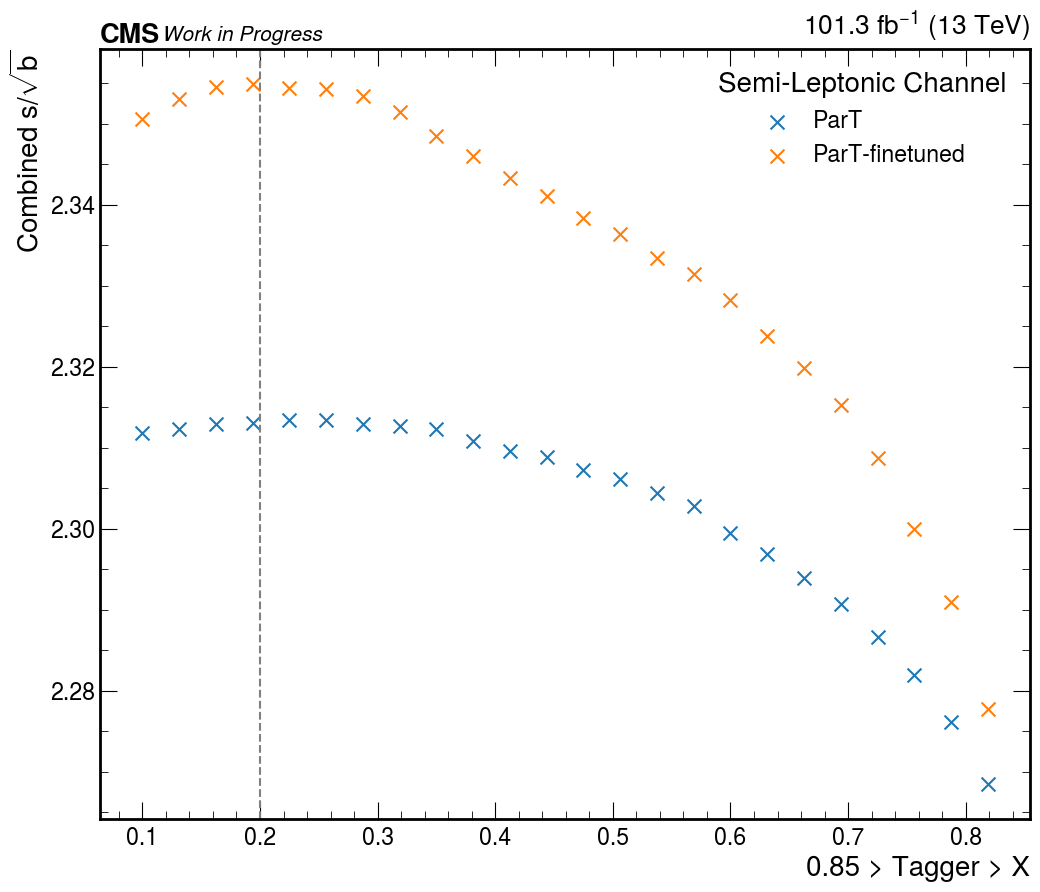

In [480]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))
years = ["2018", "2017"]


soverb_high = 2.26

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",


#         f"fj_ParT_score_finetuned_v2_10_5",
#         f"fj_ParT_score_finetuned_v2_10_12",   ### best: --start-lr 6.75e-3 --num-epochs 2500 norelu

#         f"fj_ParT_score_finetuned_v2_r1",
#         f"fj_ParT_score_finetuned_v2_r2",
#         f"fj_ParT_score_finetuned_v2_rs1",
#         f"fj_ParT_score_finetuned_v2_rs2",

#         f"fj_ParT_score_finetuned_v2_nor1",
    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.2, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"Combined $s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])


lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_low_signal_region.pdf")

# Stacked hists

In [235]:
vars_to_plot = [
#     "fj_minus_lep_m",
#     "fj_pt",
#     "lep_pt",
#     "fj_msoftdrop",
#     "fj_bjets_ophem",
#     "fj_bjets",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "ht",
#     "met_fj_dphi",
#     "deta",
#     "met",
#     "mjj",
#     "fj_pt_over_lep_pt",
    "rec_higgs_m",
#     "rec_higgs_pt",
#     "rec_higgs_pt_over_lep_pt",    
#     "golden_var",
#     "rec_dphi_WW",
#     "fj_ParT_mass",
#     "fj_ParticleNet_mass"
#     "nj",
#     "inclusive_score",
#     "fj_ParT_score_finetuned_v2_10_12",
]

samples_to_plot = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

In [405]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   

#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)"#" & (lep_fj_dr>0.3)",

}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

region = "signal_region"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                for k, v in presel.items():

                    if "QCD" in k:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]
                    
                    if "High" in k:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]

                    df = df.query(v)
                
                hists[var].fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"],
                )     

Will plot rec_higgs_m histogram


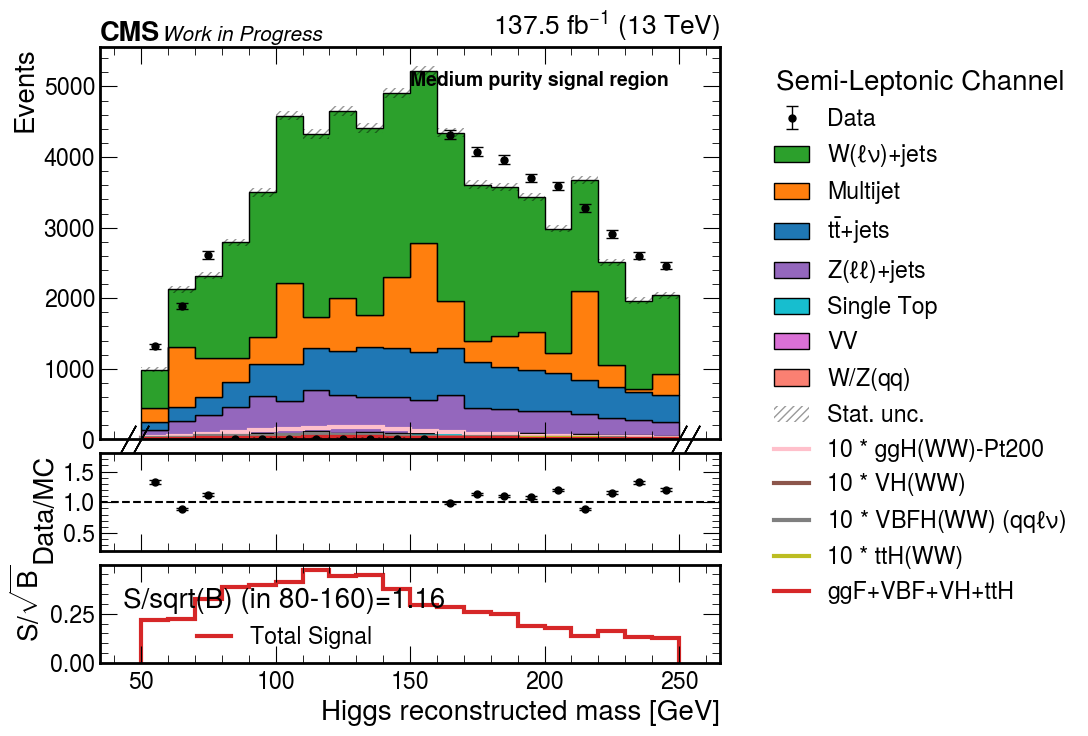

In [406]:
plt.rcParams.update({"font.size": 20})
from utils import plot_hists
plot_hists(years, channels, hists, vars_to_plot,             
            add_data=True,
            logy=False,
            add_soverb=True,
            only_sig=False,
            mult=10,
            outpath="/Users/fmokhtar/Desktop/farakikopku2/",
            text_=list(presel.keys())[0],
            blind_region=[80,160],
          )

# soverb

In [375]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [503]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    
#     "WJets control region + dR>0.3": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.3)",
#     "WJets control region + dR>0.4": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.4)",
#     "WJets control region + dR>0.5": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.5)",


#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      
#     "Top control region + dR>0.2": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.2)",  
#     "Top control region + dR>0.3": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.3)",  
#     "Top control region + dR>0.4": f"({tagger}<0.30) & (n_bjets_T>0) & (lep_fj_dr>0.4)",  

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0


VBF = False
for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                if "High" in k:
                    if sample == "QCD":
                        df = df[df["event_weight"]<140]

                df = df.query(v)  
                
                if "High" in k:
                    if sample == "QCD":
                        df = df[df["event_weight"]<140]
            
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
            
            if VBF:
                df = df[df["mjj"]>1000]
                df = df[df["deta"]>3.5]
            else:
                df = df[df["mjj"]<1000]
                df = df[df["deta"]<3.5]
            
            df = df[(df["fj_pt"]>300) & (df["fj_pt"]<2000)]
    
            if sample in utils.signals:
                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum() 

In [504]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')

print("------------------------")

print("\033[1m" + rf"s/sqrt(b): {deno_sig/math.sqrt(deno_bkg):.2f}" + '\033[0m')
print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

Medium purity signal region (Run2):
------------------------
s/sqrt(b): 0.59
------------------------
Signal: 43.90
- VBF: 9%
- ttH: 11%
- VH: 18%
- ggF: 61%
------------------------
Background: 5536.03
- Others: 3%
- QCD: 10%
- DYJets: 11%
- TTbar: 18%
- WJetsLNu: 58%


In [498]:
(0.56**2 + 0.93**2)**0.5   # VBF+ggF     (without is 1.13)

1.0855873986004074

In [505]:
(0.56**2 + 0.73**2 + 0.59**2)**0.5    # VBF / ggF200-300 / ggF300-inf

1.092977584399607

### high purity

In [424]:
(1.76**2 + 1.67**2)**0.5   # VBF+ggF

2.426211037811839

In [448]:
(1.33**2 + 1.61**2 + 0.89**2)**0.5  # ptbins 200-300/300-450/450-inf

2.2700440524359875

In [453]:
(2.01**2 + 0.89**2)**0.5  # ptbins 200-450/450-inf

2.1982265579325526

In [458]:
(1.33**2 + 1.82**2)**0.5  # ptbins 200-300/300-inf

2.2541739063346466

In [465]:
(1.76**2 + 1.01**2 + 1.45**2)**0.5   # VBF / ggF200-300 / ggF300-inf

2.4940328786926607

In [473]:
(1.76**2 + 1.57**2 + 0.65**2)**0.5   # VBF / ggF200-450 / ggF450-inf

2.4464259645450137

In [478]:
(1.76**2 + 1.01**2 + 1.3**2 + 0.65**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

2.496036858702211

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

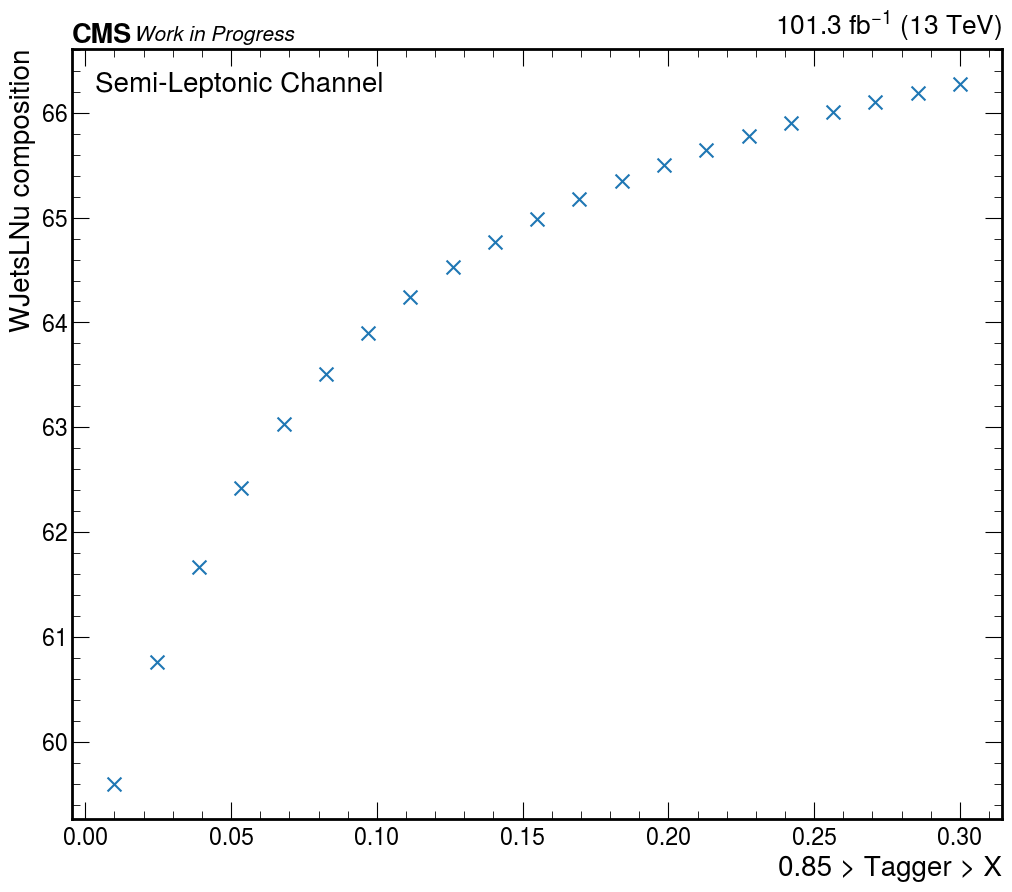

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

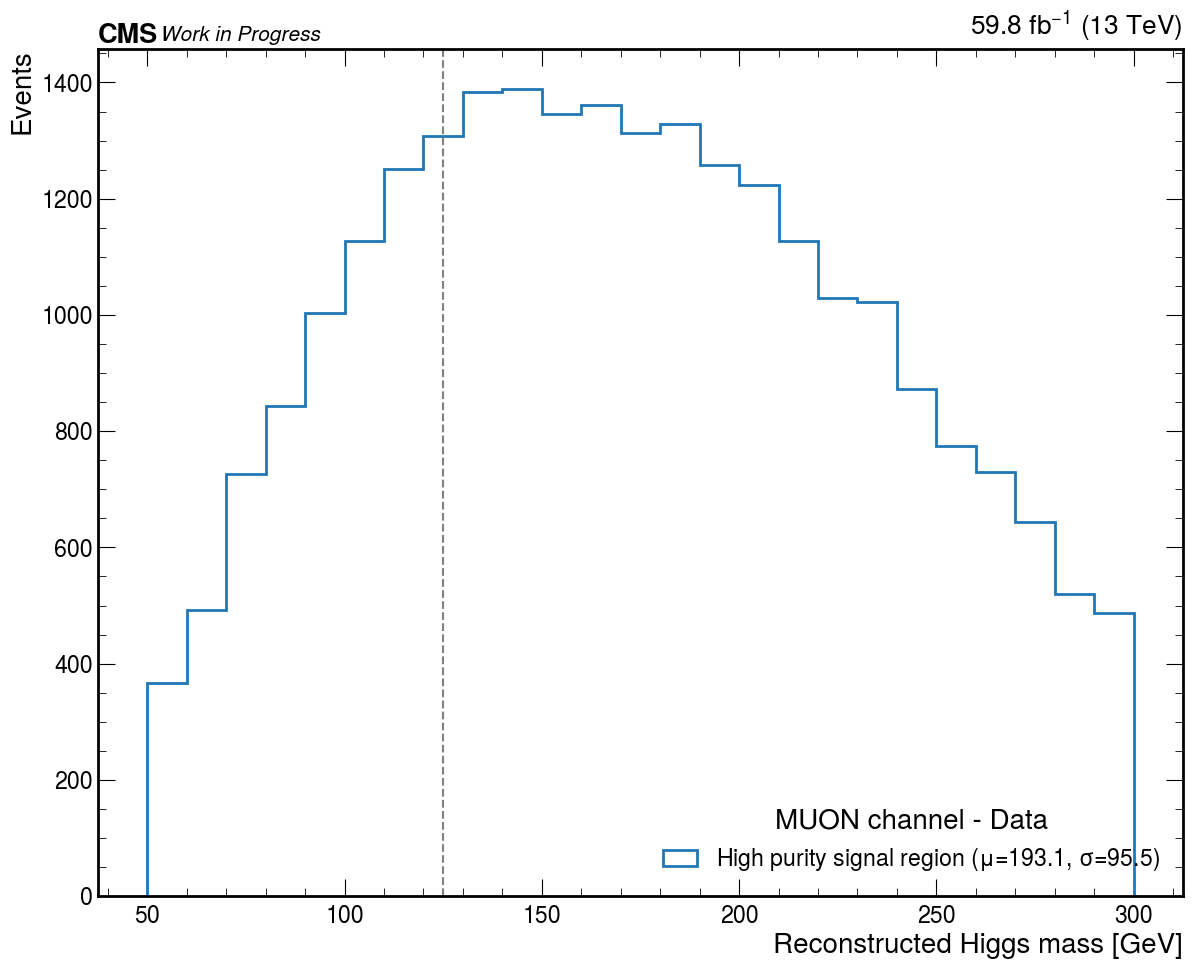

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [121]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [479]:
# ################### option 1
# plt.rcParams.update({"font.size": 20})
# nice_ch = {
#     "ele": "Electron",
#     "mu": "Muon",
# }

# # tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"

# region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
# #     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
# #     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
# #     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
# #     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
# #     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
# }


# ptbins = [
#     (200,300), 
#     (300,450), 
#     (450,650), 
#     (650, 2000)
# ]
# blind = True
# blind_region = (80, 160)
# mult = 10

# ch = "ele"
# years = ["2018", "2017", "2016APV", "2016"]

# fig, axs = plt.subplots(2, 2, figsize=(16,14), constrained_layout=True)

# VBF = True
# for i, ptbin in enumerate(ptbins):
#     xs, ws = {}, {}
#     for sample in ["Data", "ggF", "VBF"]:
#         xs[sample], ws[sample] = [], []
#         for year in years:
        
#             for region, sel in region_sel.items():
#                 if "QCD" in region:
#                     df = events_dict["qcd_region"][year][ch][sample]    
#                 else:
#                     df = events_dict["signal_region"][year][ch][sample]    
#                 df = df.query(sel)
                
#             df = df[(df["fj_pt"]>ptbin[0]) & (df["fj_pt"]<ptbin[1])]
            
#             if VBF:
#                 df = df[df["mjj"]>1000]
#                 df = df[df["deta"]>3.5]
#             else:
#                 df = df[df["mjj"]<1000]
#                 df = df[df["deta"]<3.5]
                
#             x = df["rec_higgs_m"]
#             if blind:
#                 x[(x>blind_region[0]) & (x<blind_region[1])] = 0   # blinding    

#             w = df[f"event_weight"]
            
#             if ((sample=="ggF") or (sample=="VBF")) and (mult!=1):
#                 w=w*mult
#                 lab=f"{mult} * {sample}"
#             else:
#                 lab=sample
                
#             xs[sample] += x.tolist()
#             ws[sample] += w.tolist() 

#         bins = 20
#         if i<2:
#             axs[0, i].hist(
#                 xs[sample], 
#                 weights=ws[sample],                    
#                 bins=np.linspace(50,240,bins),  
#                 histtype="step", 
#                 linewidth=2,
#                 label=lab,                    
#             )
#         else:
#             axs[1, i-2].hist(
#                 xs[sample],
#                 weights=ws[sample],                    
#                 bins=np.linspace(50,240,bins), 
#                 histtype="step", 
#                 linewidth=2, 
#                 label=lab,
#             )            

# lum = 0
# for year in years:
#     lum += luminosity[ch][year] / 1000.0

# for i, ax in enumerate([axs[0,0], axs[0,1], axs[1,0], axs[1,1]]):
#     lab = list([str(ptbin_) for ptbin_ in ptbins[i]])
#     for j, v in enumerate(lab):
#         if v=="2000":
#             lab[j] = "inf"
#     ax.legend(title=rf"$p_T$ $\in$ [{','.join(lab)}]", loc="upper left")
    
#     ax.set_ylabel(f"Events ({nice_ch[ch]} channel)")
#     ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
    
#     if i==3:
#         ax.set_ylim(0,4)
#         ax.set_yticks([0,1,2,3])
#     else:
#         ax.set_ylim(0)    

#     hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
#     hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# # plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/Data_ggF_{ch}_option1.pdf")        

In [480]:
# ################### option 2
# plt.rcParams.update({"font.size": 20})
# nice_ch = {
#     "ele": "Electron",
#     "mu": "Muon",
# }

# # tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"

# region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
# #     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
# #     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
# #     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
# #     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
# #     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
# }


# ptbins = [
#     (200,300), 
#     (300,2000), 
# ]
# blind = True
# blind_region = (80, 160)
# mult = 10

# ch = "mu"
# years = ["2018", "2017", "2016APV", "2016"]

# fig, axs = plt.subplots(1, 2, figsize=(15,7), constrained_layout=True)
    
# VBF = True
# for i, ptbin in enumerate(ptbins):
#     xs, ws = {}, {}
#     for sample in ["Data", "ggF", "VBF"]:
#         xs[sample], ws[sample] = [], []
#         for year in years:
#             for region, sel in region_sel.items():
#                 if "QCD" in region:
#                     df = events_dict["qcd_region"][year][ch][sample]    
#                 else:
#                     df = events_dict["signal_region"][year][ch][sample]    
#                 df = df.query(sel)
                
#             df = df[(df["fj_pt"]>ptbin[0]) & (df["fj_pt"]<ptbin[1])]

#             if VBF:
#                 df = df[df["mjj"]>1000]
#                 df = df[df["deta"]>3.5]
#             else:
#                 df = df[df["mjj"]<1000]
#                 df = df[df["deta"]<3.5]
                
#             x = df["rec_higgs_m"]
#             if blind:
#                 x[(x>blind_region[0]) & (x<blind_region[1])] = 0   # blinding    

#             w = df[f"event_weight"]
            
#             if ((sample=="ggF") or (sample=="VBF")) and (mult!=1):
#                 w=w*mult
#                 lab=f"{mult} * {sample}"
#             else:
#                 lab=sample
                
#             xs[sample] += x.tolist()
#             ws[sample] += w.tolist() 

#         bins = 20
#         axs[i].hist(
#             xs[sample], 
#             weights=ws[sample],
#             bins=np.linspace(50,240,bins),  
#             histtype="step", 
#             linewidth=2, 
#             label=lab
#         )          

# lum = 0
# for year in years:
#     lum += luminosity[ch][year] / 1000.0
    
# for i, ax in enumerate(axs):
#     lab = list([str(ptbin_) for ptbin_ in ptbins[i]])
#     for i, v in enumerate(lab):
#         if v=="2000":
#             lab[i] = "inf"
#     ax.legend(title=rf"$p_T$ $\in$ [{','.join(lab)}]")
    
#     ax.set_ylabel(f"Events ({nice_ch[ch]} channel)")
#     ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
#     ax.set_ylim(0)
    
#     if i==0:
#         ax.set_ylim(0, 119)        
# #         ax.set_yticks([5,10,15,20, 25])
    
#     hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
#     hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# # plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/Data_ggF_{ch}_option2.pdf")        

In [481]:
# ################### QCD
# plt.rcParams.update({"font.size": 20})
# nice_ch = {
#     "ele": "Electron",
#     "mu": "Muon",
# }

# # tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"

# region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
# #     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
# #     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
# #     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
# #     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
# #     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
# }


# ptbins = [
#     (200,300), 
#     (300,450),
#     (450,2000), 
# ]
# blind = True
# blind_region = (80, 160)

# ch = "ele"
# sample = "QCD"
# years = ["2018", "2017", "2016APV", "2016"]

# fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)
    
# for i, ptbin in enumerate(ptbins):
#     ws = []
#     for year in years:
#         df = events_dict["signal_region"][year][ch][sample]    
#         for region, sel in region_sel.items():
#             df = df.query(sel)

#         df = df[(df["fj_pt"]>ptbin[0]) & (df["fj_pt"]<ptbin[1])]
        
#         w = df[f"event_weight"]

#         ws += w.tolist() 
#     ws = np.array(ws)
#     ws = ws[ws>10]

#     axs[i].hist(
#         ws,
#         bins=np.linspace(0,340,20),  
#         histtype="step", 
#         linewidth=2, 
#     )          

# lum = 0
# for year in years:
#     lum += luminosity[ch][year] / 1000.0
    
# for i, ax in enumerate(axs):
    
#     lab = list([str(ptbin_) for ptbin_ in ptbins[i]])
#     for i, v in enumerate(lab):
#         if v=="2000":
#             lab[i] = "inf"
#     ax.legend(title=rf"$p_T$ $\in$ [{','.join(lab)}]")
    
#     ax.set_ylabel(f"QCD events ({nice_ch[ch]} channel)", labelpad=0)
#     ax.set_xlabel(f"Event weight")
#     ax.set_ylim(0)
    
# #     if i==0:
# #         ax.set_ylim(0, 119)        
# #         ax.set_yticks([5,10,15,20, 25])
    
#     hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
#     hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/QCD_weights_{ch}_option3_high.pdf")        

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


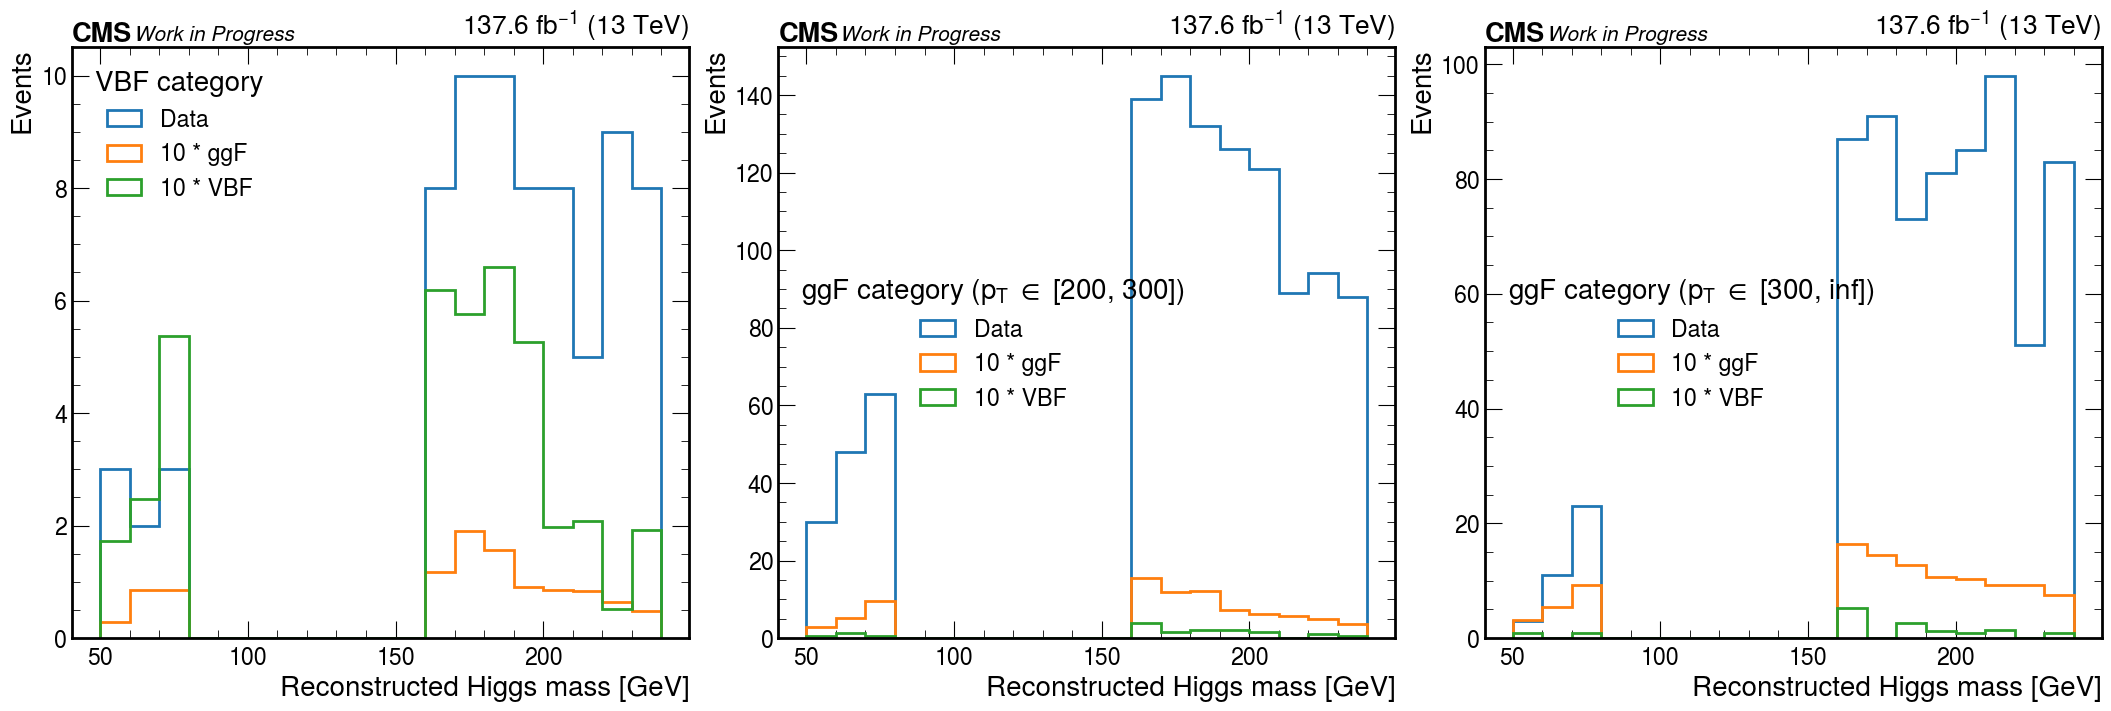

In [490]:
################### option 2
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}

categories = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [200, 300])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<300)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

blind = True
blind_region = (80, 160)
mult = 10

channels = ["mu", "ele"]
years = ["2018", "2017", "2016APV", "2016"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)
    
xs, ws = {}, {}
for i, (category, sel_category) in enumerate(categories.items()):
    for sample in ["Data", "ggF", "VBF"]:
        xs[sample], ws[sample] = [], []
        for year in years:
            
            for ch in channels:
                for region, sel in region_sel.items():
                    if "QCD" in region:
                        df = events_dict["qcd_region"][year][ch][sample]    
                    else:
                        df = events_dict["signal_region"][year][ch][sample]    
                    df = df.query(sel)
                    
                df = df.query(sel_category)

                x = df["rec_higgs_m"]
                if blind:
                    x[(x>blind_region[0]) & (x<blind_region[1])] = 0   # blinding    

                w = df[f"event_weight"]

                if ((sample=="ggF") or (sample=="VBF")) and (mult!=1):
                    w=w*mult
                    lab=f"{mult} * {sample}"
                else:
                    lab=sample

                xs[sample] += x.tolist()
                ws[sample] += w.tolist()

        axs[i].hist(
            xs[sample], 
            weights=ws[sample],
            bins=np.linspace(50,240,20),  
            histtype="step", 
            linewidth=2, 
            label=lab
        )          
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
    
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/VBF_ggF_option1.pdf")

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


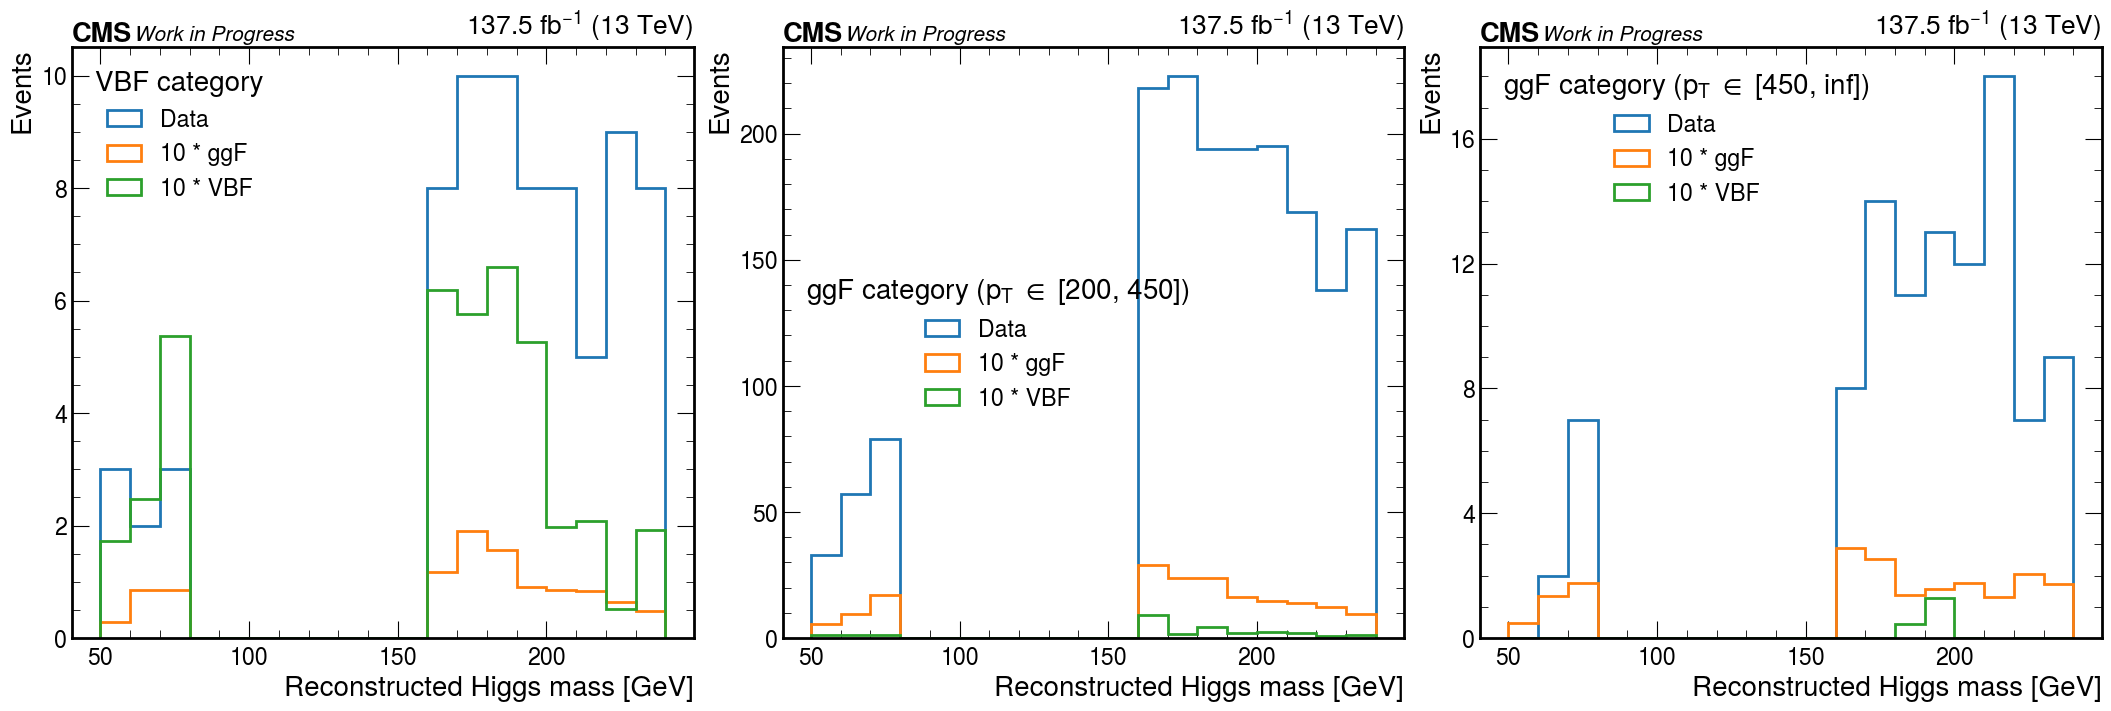

In [506]:
################### option 2
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}

categories = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
}

blind = True
blind_region = (80, 160)
mult = 10

channels = ["mu", "ele"]
years = ["2018", "2017", "2016APV", "2016"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)
    
xs, ws = {}, {}
for i, (category, sel_category) in enumerate(categories.items()):
    for sample in ["Data", "ggF", "VBF"]:
        xs[sample], ws[sample] = [], []
        for year in years:
            
            for ch in channels:
                for region, sel in region_sel.items():
                    if "QCD" in region:
                        df = events_dict["qcd_region"][year][ch][sample]    
                    else:
                        df = events_dict["signal_region"][year][ch][sample]    
                    df = df.query(sel)
                    
                df = df.query(sel_category)

                x = df["rec_higgs_m"]
                if blind:
                    x[(x>blind_region[0]) & (x<blind_region[1])] = 0   # blinding    

                w = df[f"event_weight"]

                if ((sample=="ggF") or (sample=="VBF")) and (mult!=1):
                    w=w*mult
                    lab=f"{mult} * {sample}"
                else:
                    lab=sample

                xs[sample] += x.tolist()
                ws[sample] += w.tolist()

        axs[i].hist(
            xs[sample], 
            weights=ws[sample],
            bins=np.linspace(50,240,20),  
            histtype="step", 
            linewidth=2, 
            label=lab
        )          
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
    if i==2:
        axs[i].set_yticks([0,4,8,12,16])
    
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/VBF_ggF_high.pdf")

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


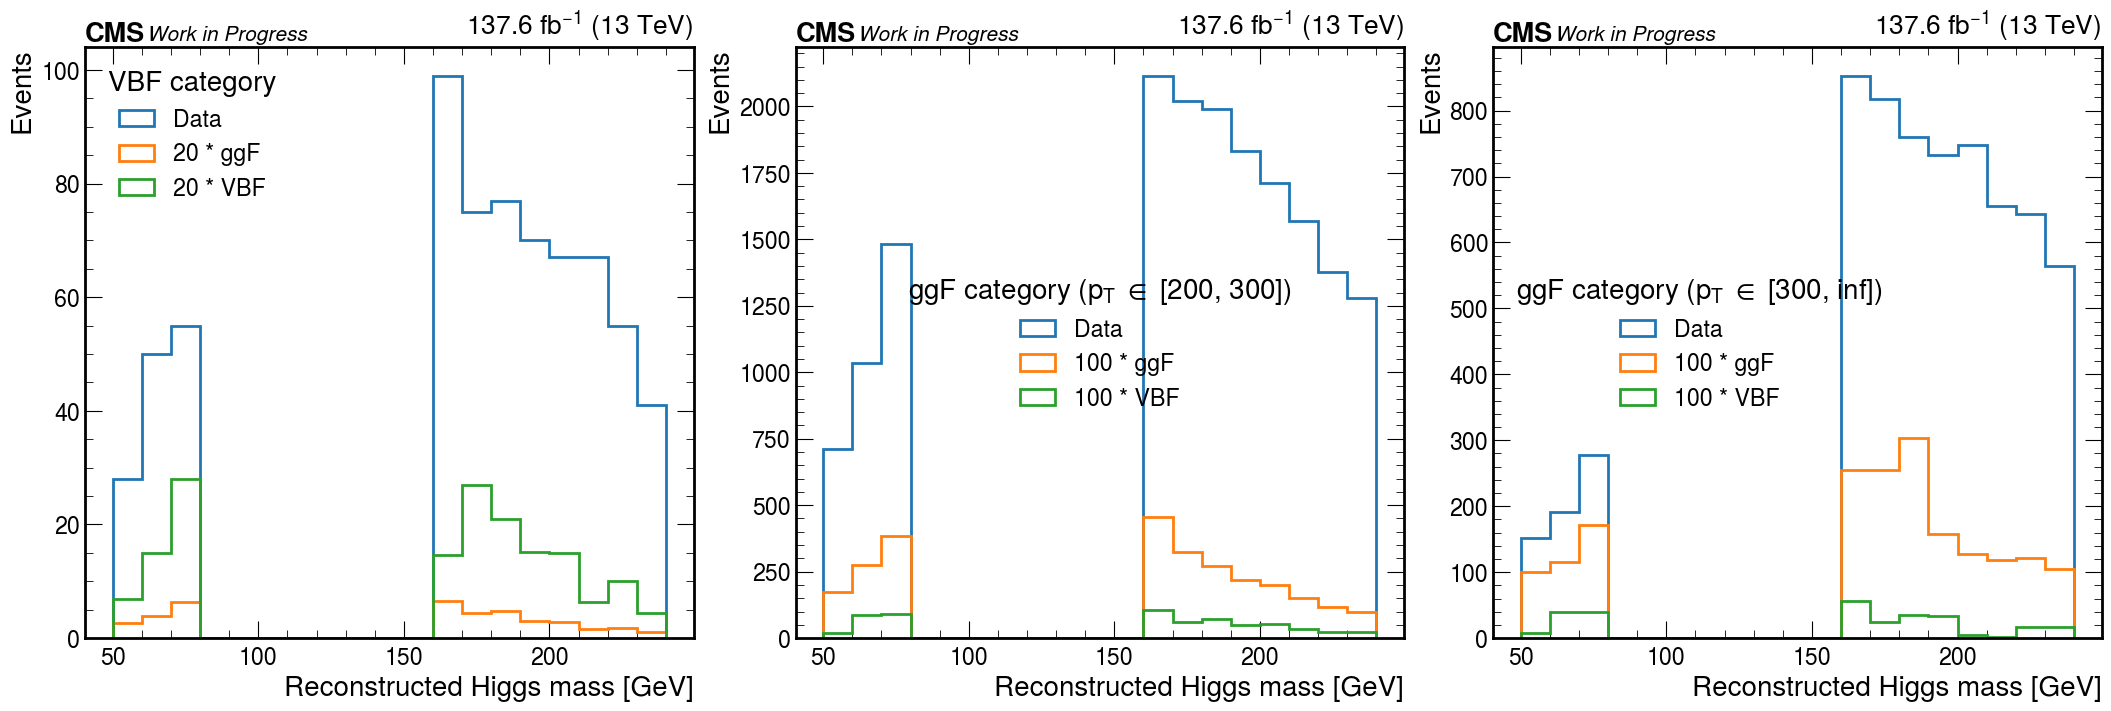

In [519]:
################### option 2
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}

categories = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    f"ggF category ($p_T$ $\in$ [200, 300])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<300)",
    f"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

blind = True
blind_region = (80, 160)
mult = 100

channels = ["mu", "ele"]
years = ["2018", "2017", "2016APV", "2016"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)
    
xs, ws = {}, {}
for i, (category, sel_category) in enumerate(categories.items()):
    for sample in ["Data", "ggF", "VBF"]:
        xs[sample], ws[sample] = [], []
        for year in years:
            
            for ch in channels:
                for region, sel in region_sel.items():
                    if "QCD" in region:
                        df = events_dict["qcd_region"][year][ch][sample]    
                    else:
                        df = events_dict["signal_region"][year][ch][sample]    
                    df = df.query(sel)
                    
                df = df.query(sel_category)

                x = df["rec_higgs_m"]
                if blind:
                    x[(x>blind_region[0]) & (x<blind_region[1])] = 0   # blinding    

                w = df[f"event_weight"]

                if ((sample=="ggF") or (sample=="VBF")) and (mult!=1):
                    if i==0:
                        w=w*20
                        lab=f"20 * {sample}"
                    else:
                        w=w*mult
                        lab=f"{mult} * {sample}"
                else:
                    lab=sample

                xs[sample] += x.tolist()
                ws[sample] += w.tolist()

        axs[i].hist(
            xs[sample], 
            weights=ws[sample],
            bins=np.linspace(50,240,20),  
            histtype="step", 
            linewidth=2, 
            label=lab
        )          
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
    
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/VBF_ggF_medium.pdf")

In [518]:
(2.49**2 + 1.09**2)**0.5

2.7181243532995323

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


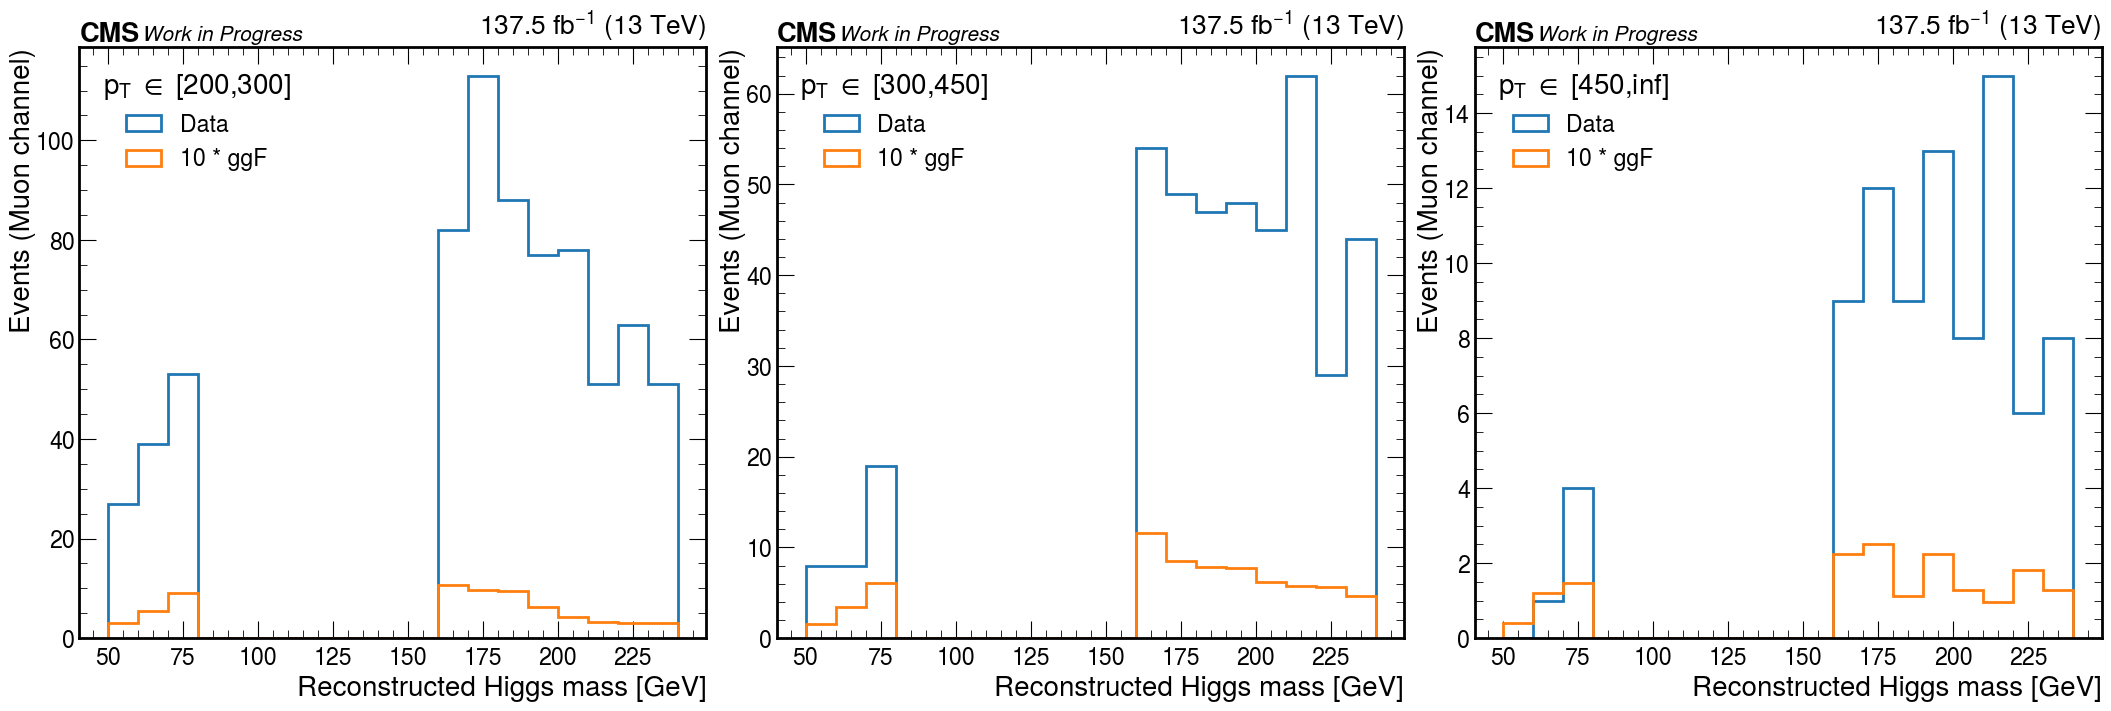

In [200]:
################### option 3
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}


ptbins = [
    (200,300), 
    (300,450),
    (450,2000), 
]
blind = True
blind_region = (80, 160)
mult = 10

ch = "mu"
years = ["2018", "2017", "2016APV", "2016"]

fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)
    
for i, ptbin in enumerate(ptbins):
    xs, ws = {}, {}
    for sample in ["Data", "ggF"]:
        xs[sample], ws[sample] = [], []
        for year in years:
            for region, sel in region_sel.items():
                if "QCD" in region:
                    df = events_dict["qcd_region"][year][ch][sample]    
                else:
                    df = events_dict["signal_region"][year][ch][sample]    
                df = df.query(sel)
                
            df = df[(df["fj_pt"]>ptbin[0]) & (df["fj_pt"]<ptbin[1])]
            
            x = df["rec_higgs_m"]
            if blind:
                x[(x>blind_region[0]) & (x<blind_region[1])] = 0   # blinding    

            w = df[f"event_weight"]
            
            if (sample=="ggF") and (mult!=1):
                w=w*mult
                lab=f"{mult} * ggF"
            else:
                lab=sample
                
            xs[sample] += x.tolist()
            ws[sample] += w.tolist() 

        bins = 20
        axs[i].hist(
            xs[sample], 
            weights=ws[sample],
            bins=np.linspace(50,240,bins),  
            histtype="step", 
            linewidth=2, 
            label=lab
        )          

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    
for i, ax in enumerate(axs):
    
    lab = list([str(ptbin_) for ptbin_ in ptbins[i]])
    for i, v in enumerate(lab):
        if v=="2000":
            lab[i] = "inf"
    ax.legend(title=rf"$p_T$ $\in$ [{','.join(lab)}]")
    
    ax.set_ylabel(f"Events ({nice_ch[ch]} channel)", labelpad=0)
    ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
    ax.set_ylim(0)
    
    if i==0:
        ax.set_ylim(0, 119)        
#         ax.set_yticks([5,10,15,20, 25])
    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/Data_ggF_{ch}_option3.pdf")        

# ggF and VBF

# QCD

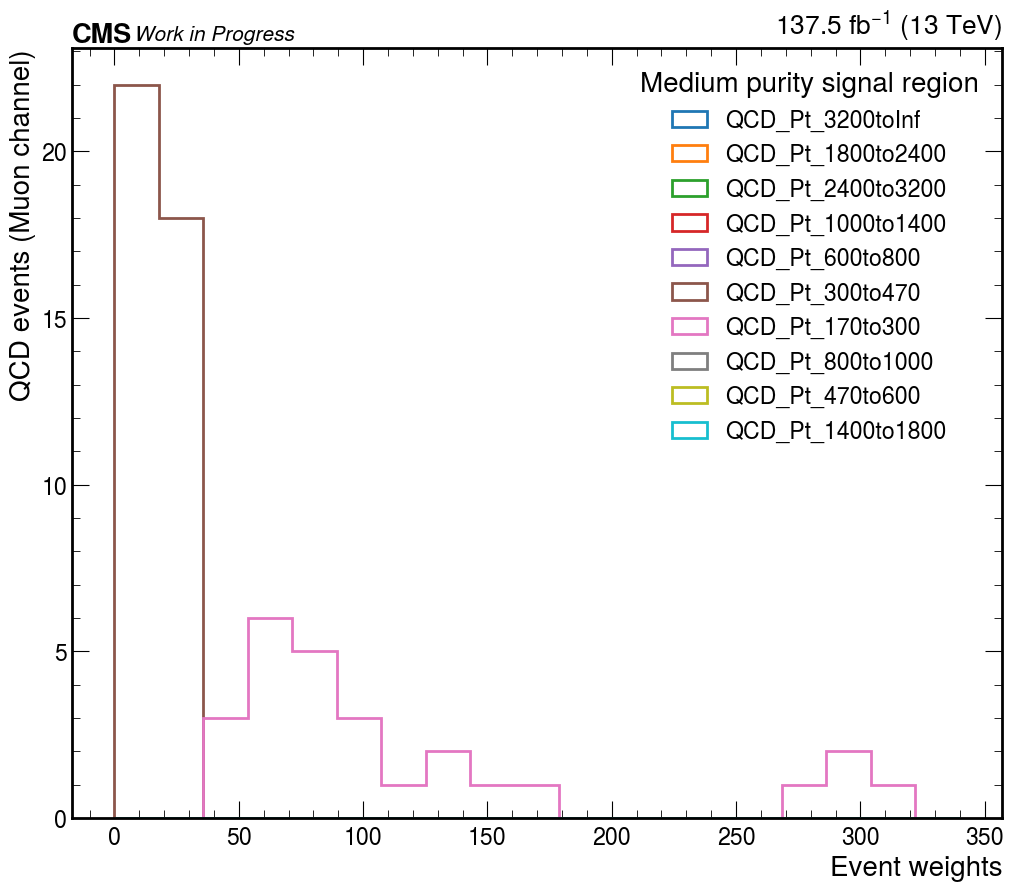

In [359]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}


blind = True
blind_region = (80, 160)
mult = 10

ch = "mu"
years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        try:
            df = events_dict2["signal_region"][year][ch][sample]
        except:
            continue
            
        for region, sel in region_sel.items():
            df = df.query(sel)

        w = df[f"event_weight"]
        ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=region)

ax.set_ylabel(f"QCD events ({nice_ch[ch]} channel)")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/ZZZ_QCD_weights_{ch}_medium.pdf")        

In [202]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1}],
        ax=ax,
        histtype="step",
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1}].values()
    tot_val = h[{"region": region2}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()


    hep.histplot(
        data_val / tot_val,
        h[{"region": region1}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=sample)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/ratio_{sample}.pdf")   

In [416]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.Regular(20, 50, 240, name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
        )        
        
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for k, v in presel.items():
                
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]
                    
                if "High" in k:
                    if sample == "QCD":
                        df = df[df["event_weight"]<140]

                df = df.query(v)

                hists[var].fill(
                    region=k,
                    var=df[var],
                    weight=df["event_weight"],
                )     

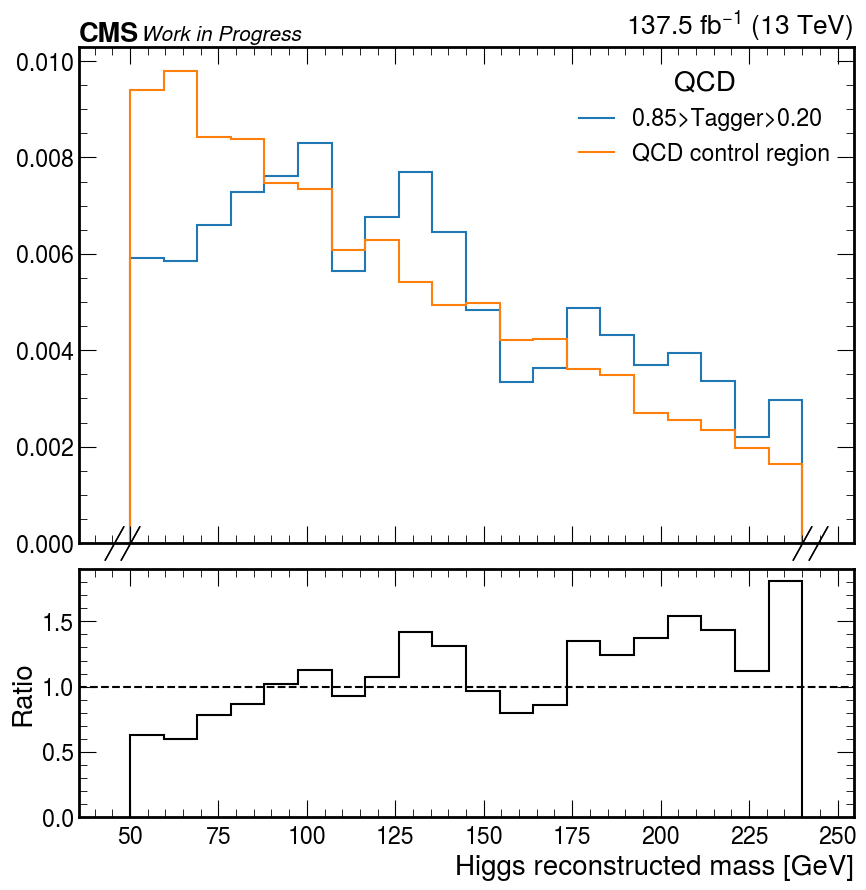

In [417]:
plot_ratio(hists["rec_higgs_m"], years, 
#            region1 = "High purity signal region", 
           region1 = "0.85>Tagger>0.20",
           region2 = "QCD control region",
           sample=sample,
           tag="low"
          )

In [307]:
data_val

array([ 80.99279675, 409.54236512,  82.26598038,  68.2721766 ,
        61.96179467, 629.3935108 ,  84.44308838, 334.59559559,
        27.88934048, 354.17824292, 677.35180032, 656.35211515,
        22.9002048 , 316.77537489,  11.40274667, 369.52659166,
       382.63748775, 316.94483475,   5.19111578,  24.54538884,
         5.00189243, 310.30746438,  67.53162891,  40.18429337,
         0.92081578,  20.98657427])

In [248]:
data_val/data_val.sum()

array([0.01510469, 0.0763773 , 0.01534213, 0.01273237, 0.01155552,
       0.11737828, 0.01574815, 0.06240016, 0.0052012 , 0.06605221,
       0.12632223, 0.1224059 , 0.00427076, 0.05907679, 0.00212655,
       0.06891459, 0.0713597 , 0.05910839, 0.00096811, 0.00457757,
       0.00093282, 0.05787056, 0.01259426, 0.00749414, 0.00017173,
       0.00391388])

In [249]:
yerr

array([[0.00085253, 0.00258319, 0.00099143, 0.00086423, 0.00060892,
        0.00243458, 0.00108837, 0.00213468, 0.00063159, 0.00290844,
        0.00295638, 0.00556874, 0.00070096, 0.00415065, 0.00070744,
        0.00403818, 0.00433611, 0.00469124, 0.00050401, 0.0014849 ,
        0.0008205 , 0.01522002, 0.00346789, 0.00346808, 0.00077798,
        0.00278738],
       [0.00095274, 0.00271405, 0.00110701, 0.00097545, 0.00069143,
        0.00253358, 0.00121351, 0.00225463, 0.00076333, 0.00306717,
        0.00307219, 0.0057904 , 0.00086398, 0.00439054, 0.00095163,
        0.00425382, 0.00456355, 0.0049623 , 0.00078277, 0.00181722,
        0.00128495, 0.01610907, 0.00391674, 0.00406092, 0.00226279,
        0.00346786]])

In [221]:
tot_val/tot_val.sum()

array([0.06907256, 0.05134574, 0.05986211, 0.06253333, 0.08453052,
       0.06754779, 0.05525016, 0.05615649, 0.05449384, 0.04240672,
       0.05770694, 0.03015714, 0.04443361, 0.02810085, 0.03083251,
       0.03119818, 0.02956601, 0.02486932, 0.02866551, 0.02172643,
       0.01726186, 0.00758466, 0.01549878, 0.01193462, 0.00657473,
       0.01068963])

In [147]:
len(h[{"region": region1}].axes.edges)

1

In [85]:
qcdx

0       148.219176
3       244.822679
4       708.026422
5       557.646437
6       805.188935
           ...    
2975    409.656266
2983    792.537073
2984    474.883550
2986     53.395040
2987    253.914229
Name: rec_higgs_m, Length: 288212, dtype: float64

In [87]:
sigx

561      571.445924
573      483.698187
1388     296.182482
3049     480.039905
4104     513.197200
           ...     
2317    1157.786586
2470     523.977852
2628     185.847641
2760    1349.163471
2873     459.066443
Name: rec_higgs_m, Length: 1649, dtype: float64

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_44458/2370009794.py:8: RuntimeWarning: invalid value encountered in divide
  ns[0] / ns[1], # maybe check for div-by-zero!


<BarContainer object of 20 artists>

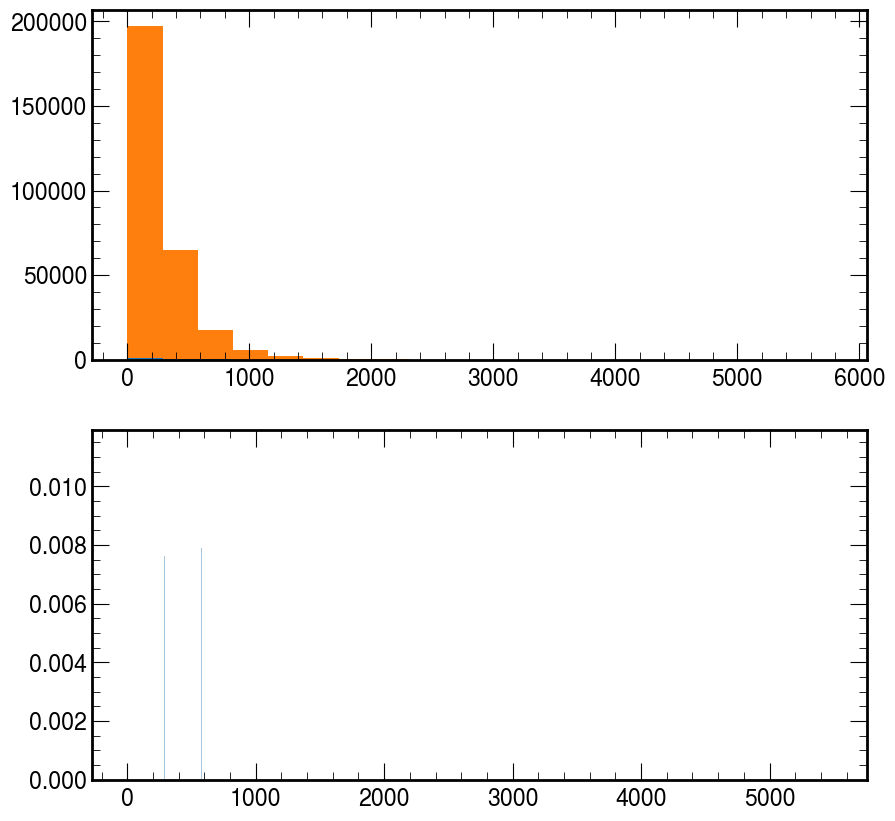

In [91]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ns, bins, patches = ax1.hist([sigx, qcdx],
                      histtype='stepfilled',
                      bins=20,
                      )

ax2.bar(bins[:-1],     # this is what makes it comparable
        ns[0] / ns[1], # maybe check for div-by-zero!
        alpha=0.4)

In [90]:
ns[0] / ns[1]

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_44458/1248563440.py:1: RuntimeWarning: divide by zero encountered in divide
  ns[0] / ns[1]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_44458/1248563440.py:1: RuntimeWarning: invalid value encountered in divide
  ns[0] / ns[1]


array([203.59504132, 131.21703854, 126.85294118, 147.24324324,
       174.        , 863.        , 394.        ,          inf,
        88.        ,          inf,          inf,          inf,
                inf,          inf,          inf,          inf,
                nan,          inf,          nan,          inf])

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

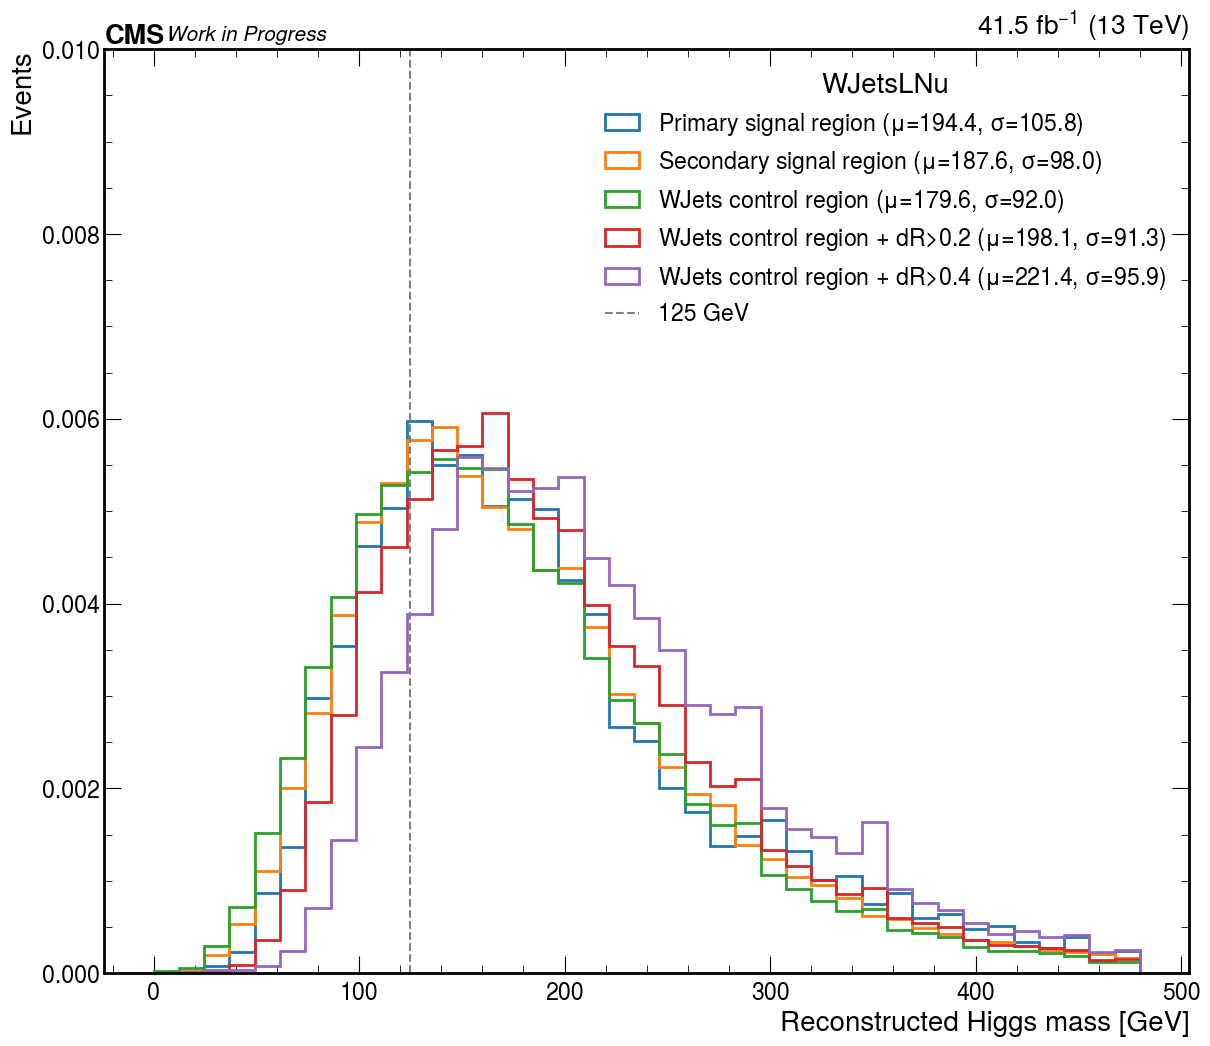

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  

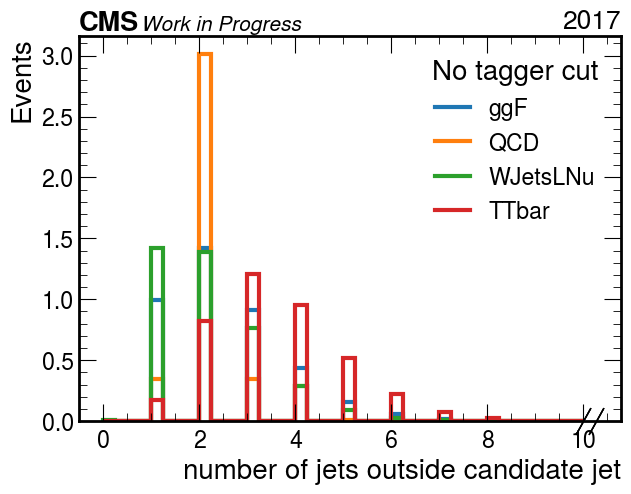

In [20]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "nj"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(7, 5))

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]

            # tagger cut
    #         df = df[df["inclusive_score"]>0.9]

    #         df = df[df["lep_fj_dr"]>0.03]        
            df = df[df["n_bjets_M"]<2]
    #         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

            h.fill(
                samples=sample,
                var=df[var],
                weight=df["event_weight"]
            )

for sample in samples_to_plot:
    if sample in utils.sig_labels:
        lab = utils.sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"No tagger cut")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

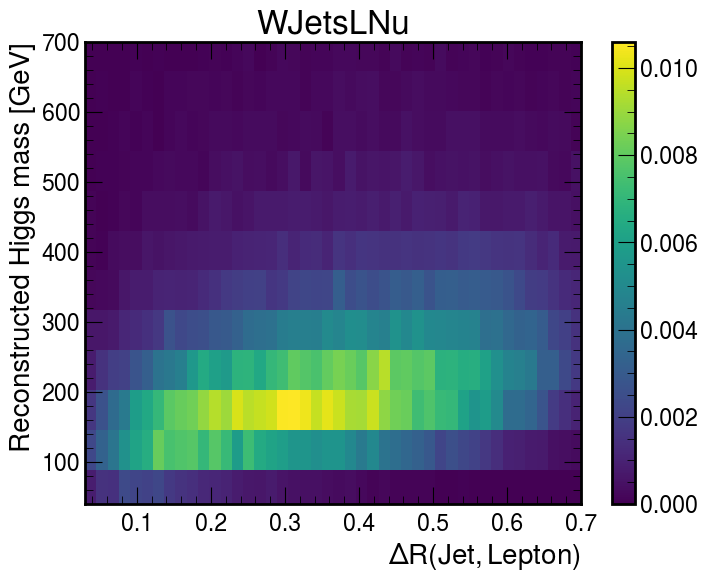

In [16]:
samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

var1 = "lep_fj_dr"
var2 = "rec_higgs_m"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))

for sample in samples_to_plot:
    for year in years:
        for i, ch in enumerate(channels):
            df = events_dict[year][ch][sample]

            df = df[df["inclusive_score"]>0.99]
            df = df[df["fj_pt"]>220]

            if i==0:
                dff = df
            else:
                dff = pd.concat([dff, df])


    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[50,50]
          )

ax.set_xlim(0.03,0.7)
ax.set_ylim(40, 700)
ax.set_xlabel(r"$\Delta R(Jet,Lepton)}$");
ax.set_ylabel(r"Reconstructed Higgs mass [GeV]");
ax.set_title(sample)
plt.colorbar()

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')